## Imports

In [1]:
import os, sys
currentdir = os.path.dirname(os.path.realpath("mandril.ipynb"))
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)

import numpy as np
import gym
import torch
import json
import numpy as np
from tqdm import trange

import maml_rl.envs
from maml_rl.baseline import LinearFeatureBaseline
from maml_rl.samplers import MultiTaskSampler
from maml_rl.utils.helpers import get_policy_for_env, get_input_size
from maml_rl.utils.reinforcement_learning import get_returns, reinforce_loss

from mazelab import MazeEnv
from mazelab.solvers import dijkstra_solver

In [2]:
def show_maze(maze, title=None):
    fig = plt.figure(figsize=(8,8))
    plt.imshow(maze)
    if title:
        plt.title(title)
    plt.show()

In [3]:
with np.load("../maml-randomShapeMaze/results.npz") as data_file:
    logs = {
        "tasks": data_file["tasks"],
        "train_returns" : data_file["train_returns"],
        "valid_returns" : data_file["valid_returns"],
        # "train_episodes" : data_file["train_episodes"],
        # "valid_episodes" : data_file["valid_episodes"],
    }

In [4]:
display(logs["tasks"].shape)
display(logs["train_returns"].shape)
display(logs["valid_returns"].shape)

(160, 10, 10)

(160, 20)

(160, 20)

In [5]:
display(logs["tasks"][0])
display(np.mean(logs["train_returns"],1))
display(np.mean(logs["valid_returns"],1))

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 1, 1, 0, 1],
       [1, 0, 0, 0, 0, 0, 1, 1, 0, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=uint8)

array([0.9460001 , 0.9635    , 0.941     , 0.9585001 , 0.9495001 ,
       0.95100003, 0.95650005, 0.9510001 , 0.95650005, 0.9545001 ,
       0.94350004, 0.9635    , 0.94900006, 0.9554998 , 0.9545    ,
       0.9639999 , 0.9725    , 0.975     , 0.9639999 , 0.959     ,
       0.96000004, 0.9660001 , 0.94649994, 0.9585001 , 0.947     ,
       0.958     , 0.95050013, 0.94750005, 0.9495001 , 0.94700015,
       0.9415    , 0.9460001 , 0.9505    , 0.95300007, 0.9545    ,
       0.949     , 0.95250005, 0.95500004, 0.952     , 0.9555    ,
       0.952     , 0.95350015, 0.94799995, 0.96049994, 0.9535    ,
       0.94350004, 0.96049994, 0.9570001 , 0.9539999 , 0.94299996,
       0.95149994, 0.952     , 0.9535    , 0.9455    , 0.95150006,
       0.95100003, 0.9535001 , 0.9639999 , 0.95699996, 0.9475001 ,
       0.95650005, 0.9635    , 0.95549995, 0.96050006, 0.95600015,
       0.95250005, 0.95650005, 0.9510001 , 0.96000004, 0.95649993,
       0.9590001 , 0.95650005, 0.9585    , 0.9599999 , 0.96500

array([-105.66051 , -107.713   ,  -69.498505, -107.32851 , -136.33052 ,
        -81.534   ,  -99.748   , -125.33101 ,  -98.7715  ,  -58.304005,
        -65.151505, -139.892   , -126.97701 ,  -91.0305  ,  -94.942   ,
        -96.727005,  -89.4085  ,  -92.619   ,  -42.538   ,  -89.51399 ,
        -97.4225  , -119.98751 ,  -52.77    ,  -42.577507,  -75.041   ,
       -115.04701 , -120.58401 , -124.763016, -138.40451 , -117.907005,
        -92.319   ,  -58.60251 , -127.179016, -107.711   , -105.447495,
       -118.37048 , -126.092   ,  -60.315002,  -88.766495, -108.218506,
        -90.596504,  -70.44499 ,  -73.964005,  -77.61951 ,  -44.1755  ,
        -99.006996, -113.80851 , -117.328   ,  -72.53001 , -100.64751 ,
        -78.6615  , -103.66951 , -158.05301 , -102.0145  ,  -87.51551 ,
       -124.90102 ,  -80.003494, -100.145996, -104.5475  ,  -90.3955  ,
        -96.6845  ,  -90.1815  , -103.95351 ,  -78.7     , -104.69    ,
        -73.40901 ,  -73.71901 ,  -90.889   ,  -77.621506,  -90.

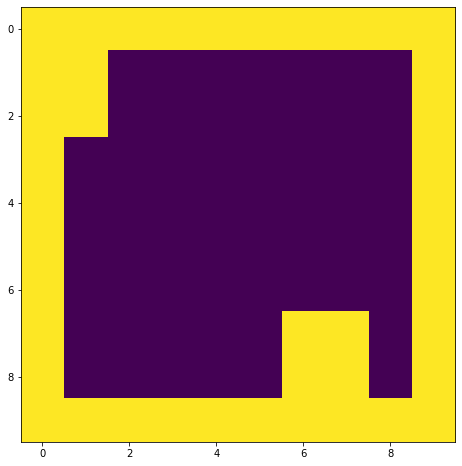

In [6]:
import matplotlib.pyplot as plt

x = logs["tasks"][0]
show_maze(x)

In [7]:
import argparse
parser = argparse.ArgumentParser(
    description='Reinforcement learning with Model-Agnostic Meta-Learning (MAML) - Test')

args = {
"config": "../maml-randomShapeMaze/config.json",
"policy": "../maml-randomShapeMaze/policy.th",

# Evaluation
"num_batches": 1,
"meta_batch_size": 1,

# Miscellaneous
"output": "maml-randomShapeMaze/results.npz",
"seed": None,
"num_workers": 1,
"device": ('cpu'),
}

height = 10
width = 10

In [8]:
try:
    gym.envs.register(
        id="RandomShapeMaze-v0",
        entry_point=MazeEnv,
        max_episode_steps=200,
        kwargs={"width": 10, "height": 10, "max_shapes": 5,
                "max_size": 2, "allow_overlap": False, "shape": None}
    )
except:
    print("environment already registered")

In [9]:
with open(args["config"], 'r') as f:
    config = json.load(f)
    if 'env-kwargs' not in config.keys(): config['env-kwargs'] = {}

env = gym.make(config['env-name'], **config['env-kwargs'])
env.close()

# configs:
fast_lr = config["fast-lr"]

In [10]:
def get_policy(policy_path):
    policy = get_policy_for_env(env,
                                hidden_sizes=config['hidden-sizes'],
                                nonlinearity=config['nonlinearity'])
    with open(policy_path, 'rb') as f:
        state_dict = torch.load(f, map_location=torch.device(args["device"]))
        policy.load_state_dict(state_dict)
    return policy
        
policy = get_policy(args["policy"])
print(policy.layer1.bias)#.params["layer1.bias"])

Parameter containing:
tensor([ 0.1688,  0.5333,  0.0310, -2.6397,  0.3514, -0.9000, -1.2096,  2.0343,
         0.9415, -2.3257,  0.4035,  0.1495, -1.0996, -1.8055, -2.0496, -3.5087],
       requires_grad=True)


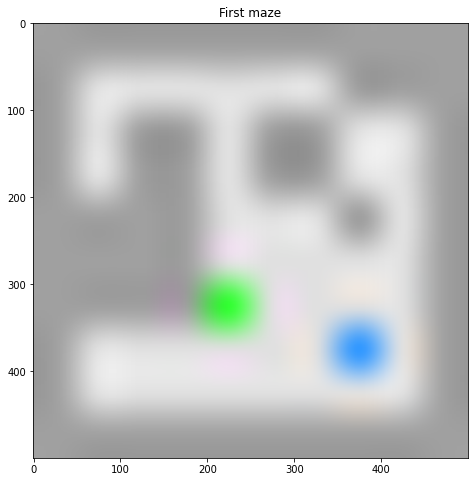

In [11]:
observations = env.reset()
img = env.render('rgb_array')
show_maze(img, "First maze")

In [12]:
def run_policy(env, observations=None, params=None):
    if observations.all == None:
        observations = env.reset()
    data = []
    path = [env.maze.objects.agent.positions[0]]
    count = 0
    reward = 0
    with torch.no_grad():
        while not (env.maze.objects.agent.positions == env.maze.objects.goal.positions) and count < 50:
            observations_tensor = torch.from_numpy(observations)
            pi = policy(observations_tensor, params=params)
            actions_tensor = pi.sample()
            actions = actions_tensor.cpu().numpy()

            new_observations, rewards, _, infos = env.step(actions)

            data.append({ "observations": observations, "actions": actions, "rewards": rewards })
            observations = new_observations
            path.append(env.maze.objects.agent.positions[0])
            count += 1
            reward += rewards
    return data, np.array(path), reward

In [13]:
def show_policy(env, params, title):
    observations = env.reset()
    maze_original = observations.reshape(height,width)
    data, path, reward = run_policy(env, observations, params)

    maze_original[path[:,0], path[:,1]] = 4
    maze_original[path[0,0], path[0,1]] = 2
    maze_original[path[-1,0], path[-1,1]] = 3
    show_maze(maze_original, title + " - reward = {0}".format(round(reward, 2)))

In [23]:
observations2 = (observations.astype(float)[None,:,:])
display(observations)
display(observations2)

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [1, 0, 1, 1, 0, 1, 1, 0, 0, 1],
       [1, 0, 1, 1, 0, 1, 1, 0, 0, 1],
       [1, 1, 1, 1, 0, 0, 0, 1, 0, 1],
       [1, 1, 1, 1, 0, 0, 0, 0, 0, 1],
       [1, 1, 1, 1, 3, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 2, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=uint8)

array([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
        [1., 0., 1., 1., 0., 1., 1., 0., 0., 1.],
        [1., 0., 1., 1., 0., 1., 1., 0., 0., 1.],
        [1., 1., 1., 1., 0., 0., 0., 1., 0., 1.],
        [1., 1., 1., 1., 0., 0., 0., 0., 0., 1.],
        [1., 1., 1., 1., 3., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 2., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]])

In [26]:
maze_original = observations.reshape(height,width)
data, path, reward = run_policy(env, observations[None,:,:].astype('float32'))

maze_original[path[:,0], path[:,1]] = 4
maze_original[path[0,0], path[0,1]] = 2
maze_original[path[-1,0], path[-1,1]] = 3
show_maze(maze_original, "Path without demonstration: reward = {0}".format(round(reward, 2)))

input dtype:  torch.float32


TypeError: only integer scalar arrays can be converted to a scalar index

## Update with example:

In [ ]:
class Episodes:
    def __init__(self, batch_size, actions, rewards, observations):
        self.batch_size = batch_size
        self.actions = actions
        self.rewards = rewards
        self.observations = observations
        self.observation_shape = observations.shape[2:]
        self._lengths = None
        
    @property
    def lengths(self):
        if self._lengths is None:
            self._lengths = [len(rewards) for rewards in self.rewards]
        return self._lengths
    
    def __len__(self):
        return max(self.lengths)

In [ ]:
def train_iter(policy, params=None):
    observations = env.reset()
    maze_image = env.get_image()
    impassable_array = env.unwrapped.maze.to_impassable()
    motions = env.unwrapped.motions
    start = env.unwrapped.maze.objects.agent.positions[0]
    goal = env.unwrapped.maze.objects.goal.positions[0]
    actions = dijkstra_solver(impassable_array, motions, start, goal)
    rewards = []
    observations = []
    for action in actions:
        observation, reward, _, infos = env.step(action)
        rewards.append(reward)
        observations.append(observation)
        
    actions      = torch.tensor([actions])
    rewards      = torch.tensor([rewards])
    observations = torch.tensor([observations])
    
    episodes = Episodes(1, actions, rewards, observations)
    
    loss = reinforce_loss(policy, episodes, params=params)
    params = policy.update_params(loss,
                                  params=params,
                                  step_size=fast_lr,
                                  first_order=True)
    print(np.array(sum(rewards[0])))
    show_maze(maze_image, "dijkstra - reward = {0}".format(round(np.array(sum(rewards[0])), 2)))
    return params

In [ ]:
params1 = train_iter(policy)

## Check outcome after 1 iteration:

In [ ]:
show_policy(env, params1, "Path after 1 demonstration")

## After 20 iterations

In [ ]:
params2 = params1
for ii in range(1):
    print(params2["layer3.bias"])
    params2 = train_iter(policy, params2)

show_policy(env, params2, "Path after 10 demonstrations")